In [1]:
#!pip install scikit-plot

In [2]:
#!pip install yellowbrick

In [3]:
#!pip install matplotlib

In [4]:
# reset all variables
%reset -f

# remove notebook checkpoints with this file name, skip if no file found
try:
    %rm -f .ipynb_checkpoints/3.5-Final-HE-Implementation-checkpoint.ipynb
except:
    pass

### Import libraries

In [5]:
import time
import pandas as pd
import torch.nn as nn
import numpy as np
import gc
import os
import scikitplot

from IPython.display import Image, display
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForestClassifier
from sklearn.neural_network import MLPClassifier as SKlearnMLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from yellowbrick.contrib.wrapper import wrap
from yellowbrick.classifier import ClassificationReport as YB_ClassificationReport

# Import model from XGBoost
from xgboost import XGBClassifier as SklearnXGBoostClassifier

# Import models from Concrete ML
from concrete.ml.sklearn import RandomForestClassifier as ConcreteRandomForestClassifier
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBoostClassifier
from concrete.ml.sklearn import NeuralNetClassifier as ConcreteMLPClassifier

# Import bindary search from Concrete ML
from concrete.ml.search_parameters import BinarySearch

CONCRETE_ML_MODELS = [
    ConcreteRandomForestClassifier,
    ConcreteXGBoostClassifier,
    ConcreteMLPClassifier,
]

In [6]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["font.family"] = "DejaVu Sans"
matplotlib.pyplot.rcParams["font.family"] = "DejaVu Sans"

### Load the dataset

In [7]:
# define sample size for experimentation
sample_train_size = 100000
sample_test_size = sample_train_size * 0.3

In [ ]:
# load transformed data that was exported from pycaret pipeline
x_train = pd.read_csv('X_train_transformed.csv')
x_train = x_train.drop(columns=['Unnamed: 0'])


x_test = pd.read_csv('X_test_transformed.csv')
x_test = x_test.drop(columns=['Unnamed: 0'])


y_train = pd.read_csv('y_train_transformed.csv')
y_train = y_train.drop(columns=['Unnamed: 0'])


y_test = pd.read_csv('y_test_transformed.csv')
y_test = y_test.drop(columns=['Unnamed: 0'])


### FHE with Concrete ML
Define the scikit-learn models and build the FHE equivalent model using Concrete ML. Then, evaluate and compare them side by side using accuracy, F1 score, recall, precision. For Concrete ML models, the inference's execution time is provided when done in FHE.

In [ ]:
def evaluate(
    model, x_train, x_test, y_train, y_test, show_circuit=False, predict_in_fhe=True, fhe_samples=None
):
    """Evaluate the given model using several metrics.

    The model is evaluated using the following metrics: accuracy, F1 score, precision, recall.
    For Concrete ML models, the inference's execution time is provided when done in FHE.

    Args:
        model: The initialized model to consider.
        x_train: Input data.
        x_test: Input data.
        y_train: Target data.
        y_test: Target data.
        show_circuit: If the FHE circuit should be printed for Concrete ML models. Default to False.
        predict_in_fhe: If the inference should be executed in FHE for Concrete ML models. Else, it
            will only be simulated.
        fhe_sample: The number of samples to consider for evaluating the inference of Concrete ML
            models if predict_in_fhe is set to True. If None, the complete test set is used. Default
            to None.
    """
    evaluation_result = {}

    is_concrete_ml = model.__class__ in CONCRETE_ML_MODELS

    name = model.__class__.__name__ + (" (Concrete ML)" if is_concrete_ml else " (sklearn)")

    evaluation_result["name"] = name

    print(f"Evaluating model {name}")
   
    x_train, x_test = x_train.astype("float32"), x_test.astype("float32")
    
    test_length = len(x_test)

    evaluation_result["Testset Count"] = test_length

    # Train the model
    model.fit(x_train, y_train)
  
    # Run the prediction non-quantized in the clear
    y_pred = model.predict(x_test, fhe="disable")
    
    # Evaluate the model
    # For Concrete ML models, this will execute the (quantized) inference in the clear
    evaluation_result["Accuracy (clear)"] = accuracy_score(y_test, y_pred)
    evaluation_result["F1 (clear)"] = f1_score(y_test, y_pred, average="binary")
    evaluation_result["Precision (clear)"] = precision_score(y_test, y_pred, average="binary")
    evaluation_result["Recall (clear)"] = recall_score(y_test, y_pred, average="binary")

    # show classification report
    cr_visualizer = YB_ClassificationReport(
        wrap(model),
        support= True,
        is_fitted = True,
        title = f"{model.__class__.__name__} Classification Report"
    )

    cr_visualizer.score(x_test, y_test)
    cr_visualizer.show(outpath=f"{model.__class__.__name__} Classification Report.png")
    plt.close()

    # show confusion matrix
    scikitplot.metrics.plot_confusion_matrix(
        y_test,
        y_pred,
        title = f"{model.__class__.__name__} Confusion Matrix"
    )
    plt.savefig(
        f"{model.__class__.__name__} Confusion Matrix.png"
    )
    plt.close()

    # show learning curve
    print("Creating Learning Curve")

    try: # parallel with n_jobs = -1
        scikitplot.estimators.plot_learning_curve(
            model,
            x_train,
            y_train,
            title = f"{model.__class__.__name__} Recall Learning Curve",
            scoring = "recall",
            n_jobs = -1,
        )
        
        plt.grid(True)
        plt.gca().set_ylim([0, 1])
        plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.4f}"))
        plt.savefig(f"{model.__class__.__name__} Recall Learning Curve.png")
        plt.close()
    except Exception as e: # catch memory exception and run non-parallel
        # print(e)
        print("Running non parallel job")

        scikitplot.estimators.plot_learning_curve(
            model,
            x_train,
            y_train,
            title = f"{model.__class__.__name__} Recall Learning Curve",
            scoring = "recall",
        )
        
        plt.grid(True)
        plt.gca().set_ylim([0, 1])
        plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.4f}"))
        plt.savefig(f"{model.__class__.__name__} Recall Learning Curve.png")
        plt.close()
    
    # If the model is from Concrete ML
    if is_concrete_ml:
        
        print("Compile the model")

        # Compile the model using the training data
        # circuit = model.compile(x_train, p_error=p_error)
        circuit = model.compile(x_train)
        
        circuit.client.keygen(force=True)

        # Print the FHE circuit if needed
        if show_circuit:
            print(circuit)

        # Retrieve the circuit's max bit-width
        # evaluation_result["max bit-width"] = circuit.graph.maximum_integer_bit_width()

        if predict_simulated:
            if fhe_samples is not None:
                x_test = x_test[0:fhe_samples]
                y_test = y_test[0:fhe_samples]
                test_length = fhe_samples

            evaluation_result["Sim Testset samples"] = test_length

            print("Predict (simulated)")

            before_time = time.time()

            # Run the prediction quantized in the clear using FHE simulation, store its execution time and evaluate the performance scores
            y_pred_simulate = model.predict(x_test, fhe="simulate")

            evaluation_result["FHE simulation (seconds per sample)"] = (
                time.time() - before_time
            ) / test_length
            evaluation_result["Accuracy (FHE-simulated)"] = accuracy_score(y_test, y_pred_simulate)
            evaluation_result["F1 (FHE-simulated)"] = f1_score(y_test, y_pred_simulate, average="binary")
            evaluation_result["Precision (FHE-simulated)"] = precision_score(y_test, y_pred_simulate, average="binary")
            evaluation_result["Recall (FHE-simulated)"] = recall_score(y_test, y_pred_simulate, average="binary")

            # save fhe_samples to csv
            x_test.to_csv("x_test_simulated_samples.csv")
            y_test.to_csv("y_test_simulated_samples.csv")
            
            # show classification report
            cr_visualizer = YB_ClassificationReport(
                wrap(model),
                support= True,
                is_fitted = True,
                title = f"Simulated {model.__class__.__name__} Classification Report"
            )

            cr_visualizer.score(x_test, y_test)
            cr_visualizer.show(outpath=f"Simulated {model.__class__.__name__} Classification Report.png")
            plt.close()

            # show confusion matrix
            scikitplot.metrics.plot_confusion_matrix(
                y_test,
                y_pred_simulate,
                title = f"Simulated {model.__class__.__name__} Confusion Matrix"
            )
            plt.savefig(
                f"Simulated {model.__class__.__name__} Confusion Matrix.png"
            )
            plt.close()

        # Run the prediction in FHE, store its execution time and evaluate the performance scores
        if predict_in_fhe:
            if fhe_samples is not None:
                x_test = x_test[0:fhe_samples]
                y_test = y_test[0:fhe_samples]
                test_length = fhe_samples

            evaluation_result["FHE Testset samples"] = test_length

            print("Predict (FHE)")

            before_time = time.time()

            y_pred_fhe = model.predict(x_test, fhe="execute")
            
            evaluation_result["FHE execution (seconds per sample)"] = (
                time.time() - before_time
            ) / test_length
            evaluation_result["Accuracy (FHE)"] = accuracy_score(y_test, y_pred_fhe)
            evaluation_result["F1 (FHE)"] = f1_score(y_test, y_pred_fhe, average="binary")
            evaluation_result["Precision (FHE)"] = precision_score(y_test, y_pred_fhe, average="binary")
            evaluation_result["Recall (FHE)"] = recall_score(y_test, y_pred_fhe, average="binary")

            # save fhe_samples to csv
            x_test.to_csv("x_test_fhe_samples.csv")
            y_test.to_csv("y_test_fhe_samples.csv")

            # show classification report
            cr_visualizer = YB_ClassificationReport(
                wrap(model),
                support= True,
                is_fitted = True,
                title = f"FHE {model.__class__.__name__} Classification Report"
            )

            cr_visualizer.score(x_test, y_test)
            cr_visualizer.show(outpath=f"FHE {model.__class__.__name__} Classification Report.png")
            plt.close()

            # show confusion matrix
            scikitplot.metrics.plot_confusion_matrix(
                y_test,
                y_pred_fhe,
                title = f"FHE {model.__class__.__name__} Confusion Matrix"
            )
            plt.savefig(
                f"FHE {model.__class__.__name__} Confusion Matrix.png"
            )
            plt.close()

    print(evaluation_result)
    print("Done !\n")

    return evaluation_result

### Run the evaluation
Evaluate several classifiers: random forest, XGBoost, and MLP NN.

In [10]:
# Determine the type of models to evaluate
use_rf = True
use_xgb = True
use_mlp = True

# Determine the FHE run type
predict_simulated = False
predict_in_fhe = True

In [ ]:
results = []

# For testing FHE execution locally, define the number of inference to run. If None, the complete test set is used
fhe_samples = 128 * 40 

# Define the initialization parameters for tree-based models
init_params_rf = {"max_depth": 6, "n_estimators": 6, "criterion": 'entropy', 'n_jobs': -1, 'random_state': 321} 
rf_params_cml = {"n_bits": 3} # parameter for which the training and test data is quantized

init_params_xgb = {"max_depth": 6, "n_estimators": 8, "booster": 'gbtree', 'n_jobs': -1, 'random_state': 123} 
xgb_params_cml = {"n_bits": 3} # parameter for which the training and test data is quantized

In [12]:
# MLP NN model
if use_mlp:

    # Define the initialization parameters for the MLP model
    params = {
    "module__n_w_bits": 3, #4
    "module__n_a_bits": 3, #4
    "module__n_accum_bits": 16, 
    "module__n_layers": 2,
    "module__n_hidden_neurons_multiplier": 4,
    "module__n_prune_neurons_percentage": 0.5,
    "module__activation_function": nn.ReLU,
    "max_epochs": 2,
    "verbose": 0,
    "batch_size": 128, #128
    "lr": 0.01, #0.001
    }

    # Concrete ML model
    results.append(
        evaluate(
            ConcreteMLPClassifier(**params),
            x_train=x_train,
            x_test=x_test,
            y_train=y_train,
            y_test=y_test,
            predict_in_fhe=predict_in_fhe,
            fhe_samples=fhe_samples,
        )
    )


Evaluating model NeuralNetClassifier (Concrete ML)
Creating Learning Curve
Compile the model
Predict (FHE)
{'name': 'NeuralNetClassifier (Concrete ML)', 'Testset Count': 506493, 'Accuracy (clear)': 0.9936010961651988, 'F1 (clear)': 0.9809718952368092, 'Precision (clear)': 0.9978738906606467, 'Recall (clear)': 0.964632935362446, 'FHE Testset samples': 5120, 'FHE execution (seconds per sample)': 0.27878951095044613, 'Accuracy (FHE)': 0.993359375, 'F1 (FHE)': 0.9800469483568074, 'Precision (FHE)': 0.9964200477326969, 'Recall (FHE)': 0.964203233256351}
Done !



In [13]:
# Random Forest
if use_rf:

    # Concrete ML model
    results.append(
        evaluate(
            ConcreteRandomForestClassifier(**init_params_rf, **rf_params_cml),
            x_train=x_train,
            x_test=x_test,
            y_train=y_train,
            y_test=y_test,
            predict_in_fhe=predict_in_fhe,
            fhe_samples=fhe_samples,
        )
    )

Evaluating model RandomForestClassifier (Concrete ML)
Creating Learning Curve
Compile the model
Predict (FHE)
{'name': 'RandomForestClassifier (Concrete ML)', 'Testset Count': 506493, 'Accuracy (clear)': 0.9869494741289613, 'F1 (clear)': 0.9609499615998109, 'Precision (clear)': 0.983862382657505, 'Recall (clear)': 0.9390804332263354, 'FHE Testset samples': 5120, 'FHE execution (seconds per sample)': 0.14434831063263118, 'Accuracy (FHE)': 0.9875, 'F1 (FHE)': 0.9623085983510012, 'Precision (FHE)': 0.9819711538461539, 'Recall (FHE)': 0.9434180138568129}
Done !



In [14]:
# XGBoost
if use_xgb:

    # Concrete ML model
    results.append(
        evaluate(
            ConcreteXGBoostClassifier(**init_params_xgb, **xgb_params_cml),
            x_train=x_train,
            x_test=x_test,
            y_train=y_train,
            y_test=y_test,
            predict_in_fhe=predict_in_fhe,
            fhe_samples=fhe_samples,
        )
    )

Evaluating model XGBClassifier (Concrete ML)
Creating Learning Curve
Compile the model
Predict (FHE)
{'name': 'XGBClassifier (Concrete ML)', 'Testset Count': 506493, 'Accuracy (clear)': 0.9921321716193511, 'F1 (clear)': 0.9764623190374654, 'Precision (clear)': 0.9995404911907324, 'Recall (clear)': 0.954425790360945, 'FHE Testset samples': 5120, 'FHE execution (seconds per sample)': 0.14420445947907864, 'Accuracy (FHE)': 0.9927734375, 'F1 (FHE)': 0.978196817913966, 'Precision (FHE)': 0.9987966305655837, 'Recall (FHE)': 0.9584295612009238}
Done !



### Compare the models

Compare the model performance results.

In [15]:
pd.set_option("display.precision", 6)

results_dataframe = pd.DataFrame(results)
results_dataframe.fillna("")

display(results_dataframe)
results_dataframe.to_csv("ResultsTable.csv")

,name,Testset Count,Accuracy (clear),F1 (clear),Precision (clear),Recall (clear),FHE Testset samples,FHE execution (seconds per sample),Accuracy (FHE),F1 (FHE),Precision (FHE),Recall (FHE)
0,NeuralNetClassifier (Concrete ML),506493,0.993601,0.980972,0.997874,0.964633,5120,0.278790,0.993359,0.980047,0.996420,0.964203
1,RandomForestClassifier (Concrete ML),506493,0.986949,0.960950,0.983862,0.939080,5120,0.144348,0.987500,0.962309,0.981971,0.943418
2,XGBClassifier (Concrete ML),506493,0.992132,0.976462,0.999540,0.954426,5120,0.144204,0.992773,0.978197,0.998797,0.958430


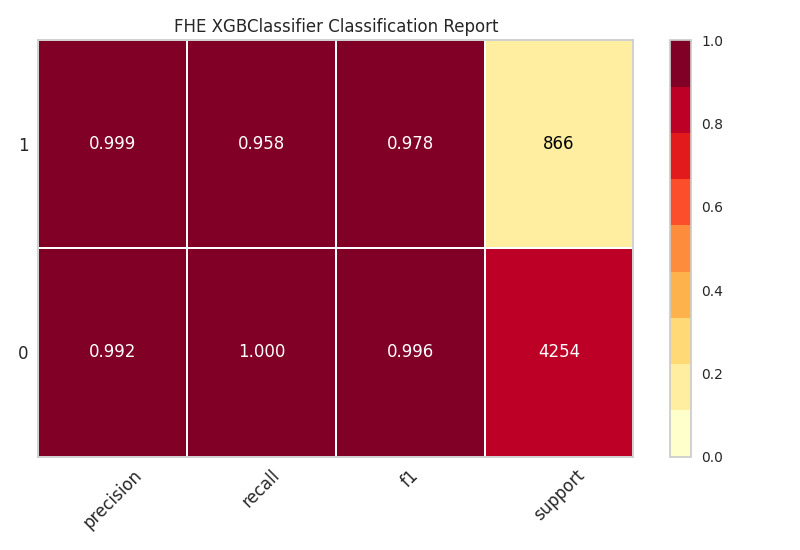

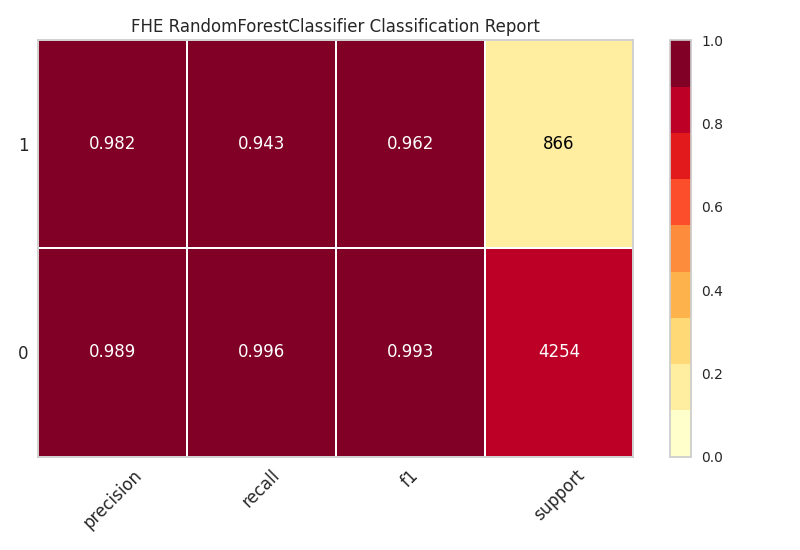

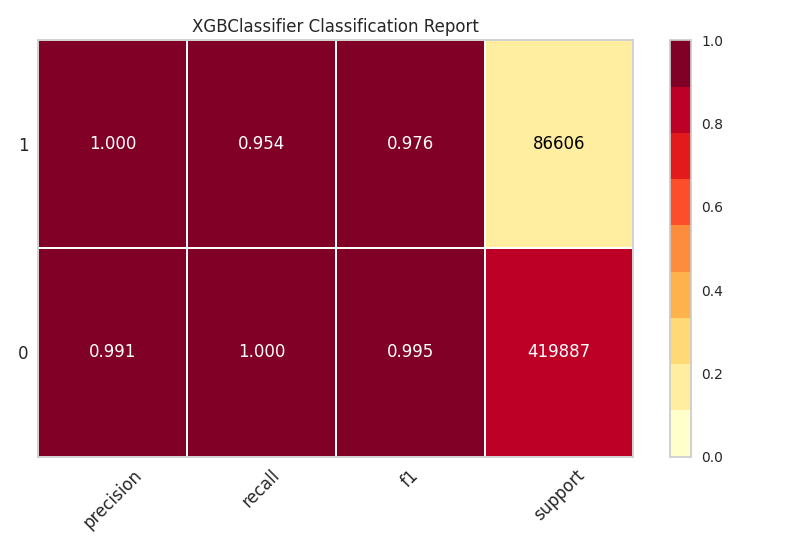

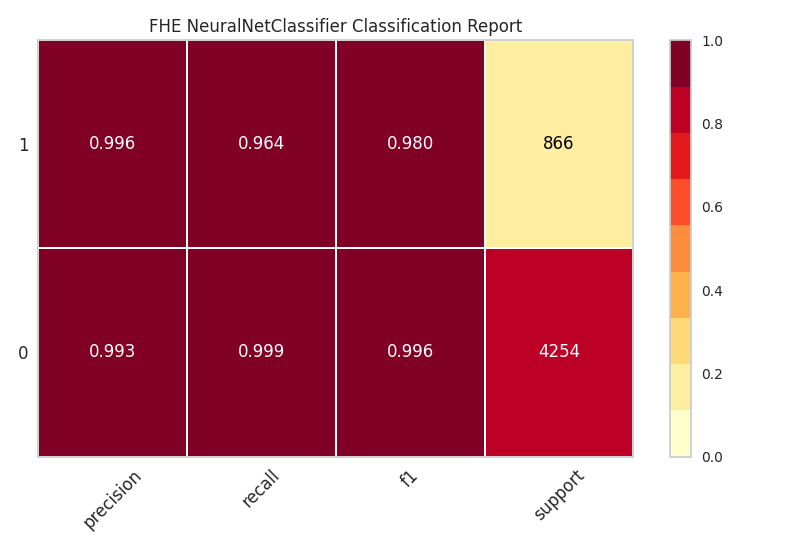

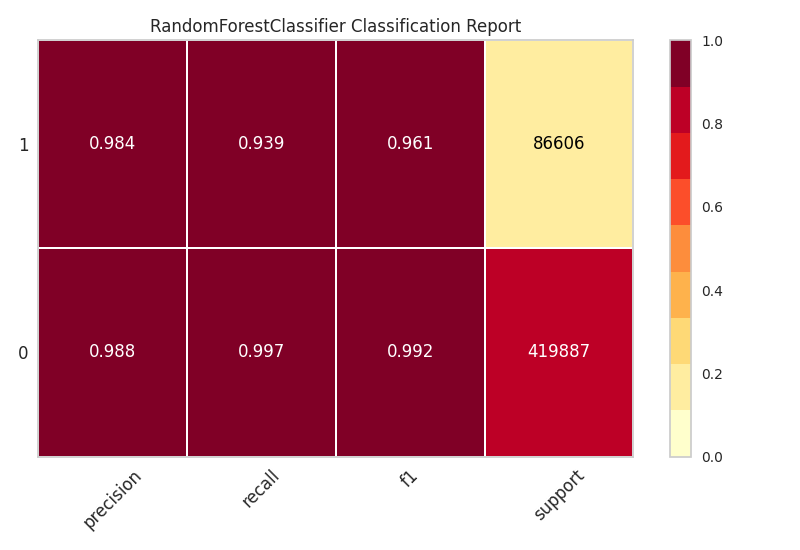

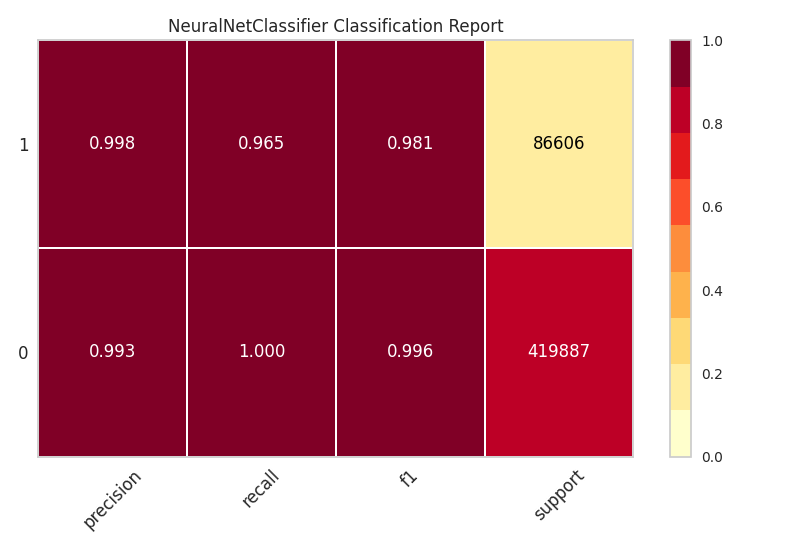

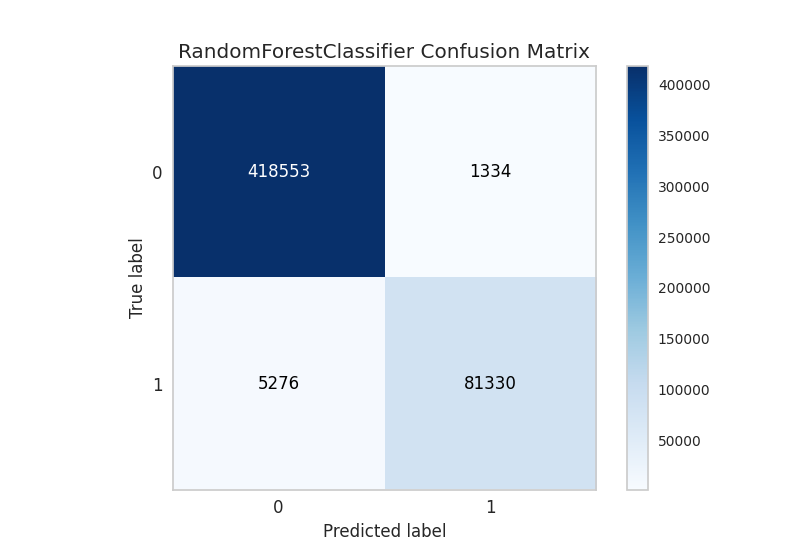

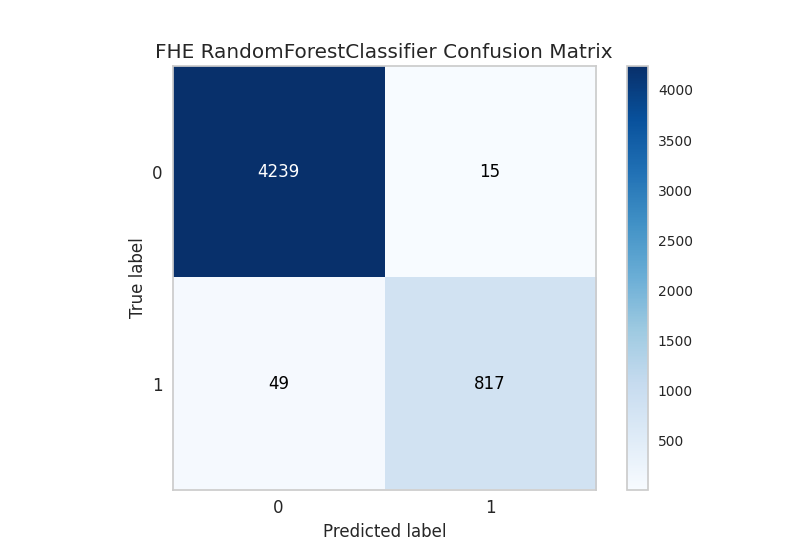

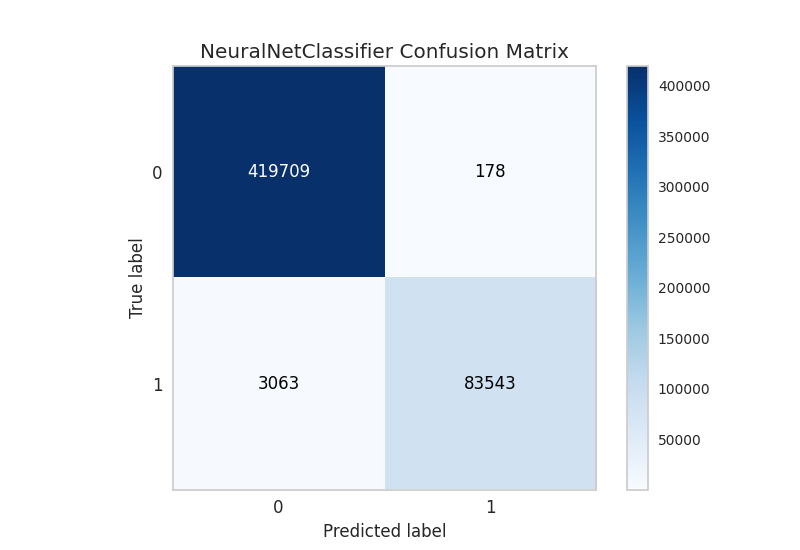

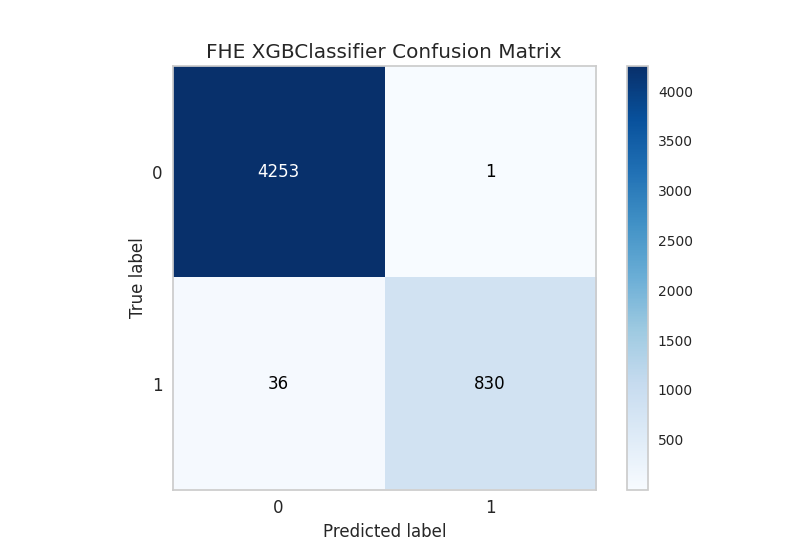

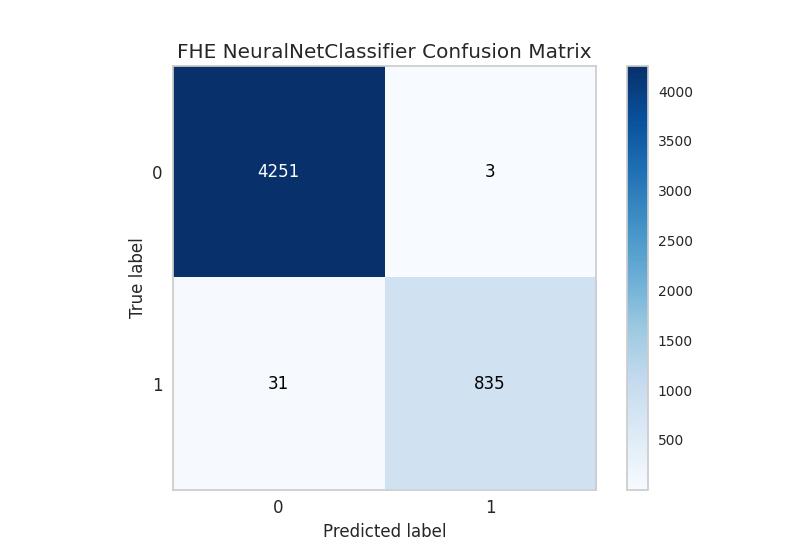

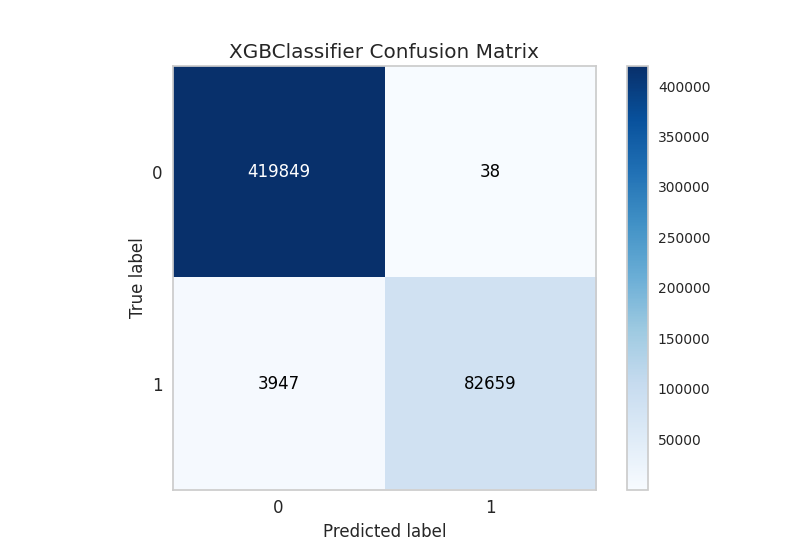

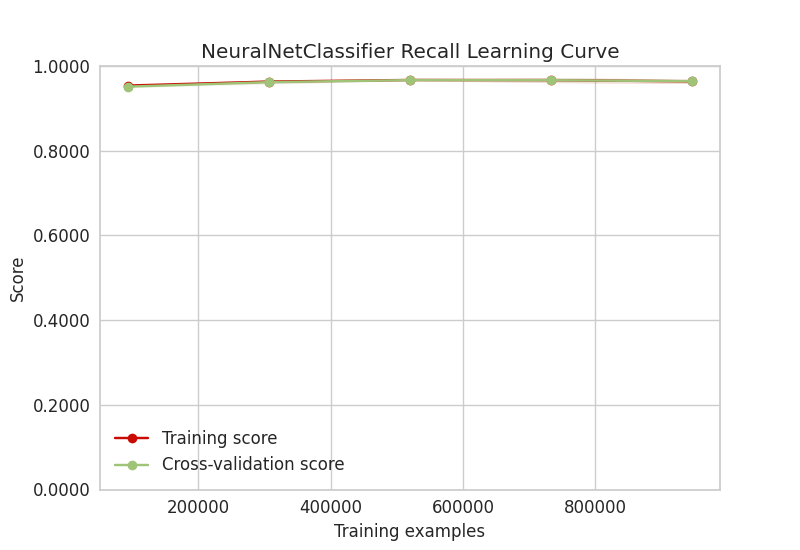

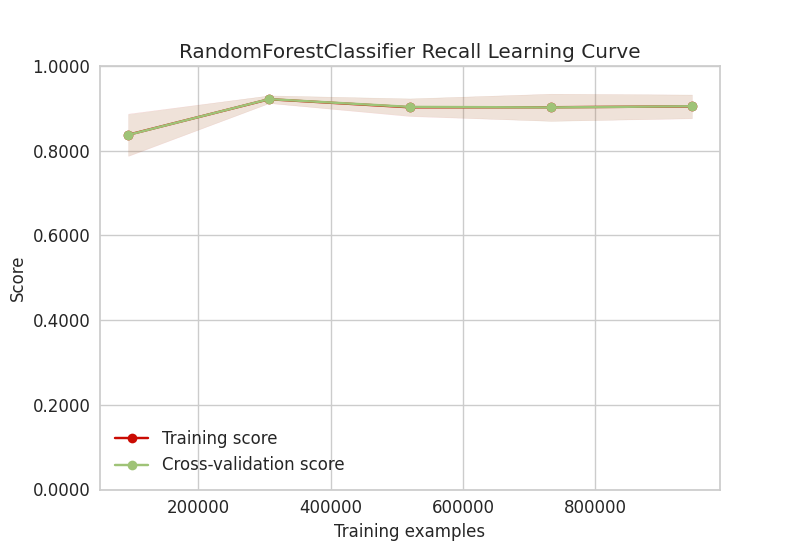

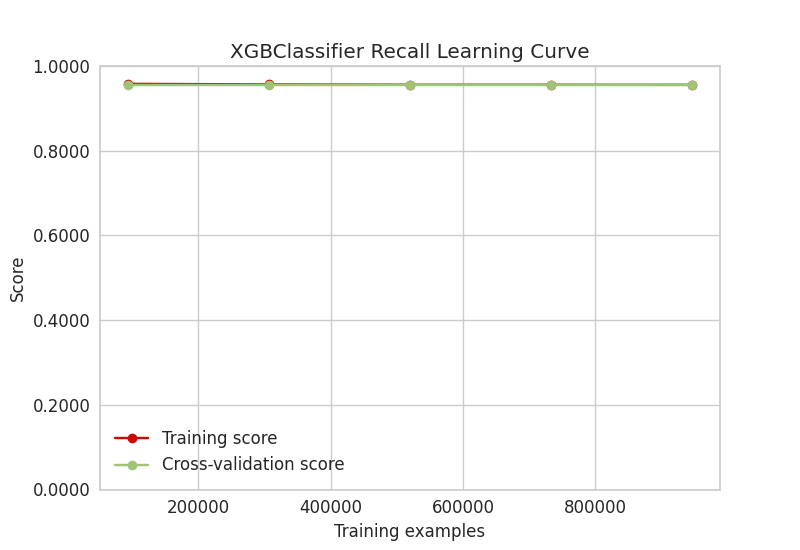

In [16]:
# show CR plots
CR_plots = [f for f in os.listdir('.') if f.endswith('Classification Report.png')]
for png in CR_plots:
    display(Image(filename=png))

# show CM plots
CR_plots = [f for f in os.listdir('.') if f.endswith('Confusion Matrix.png')]
for png in CR_plots:
    display(Image(filename=png))

CR_plots = [f for f in os.listdir('.') if f.endswith('Learning Curve.png')]
for png in CR_plots:
    display(Image(filename=png))